# Data validation
This is a mostly manual sectio, where we check data validity and inconcistencies. Also, it is important for the data to be resilient to bugs.

In [109]:
import os
import pickle as pkl
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# %matplotlib inline
warnings.filterwarnings('ignore')

In [110]:
sys.path.append(os.path.join('..', 'src'))

In [111]:
import importlib
import utils
importlib.reload(utils)
from utils import reorder_label_cols

import params
importlib.reload(params)
from params import ProjectParameters

In [112]:
import importlib
import utils
importlib.reload(utils)
from utils import capture_data

import params
importlib.reload(params)
from params import ProjectParameters

# set image building to True/False
* if build_images == False: faster to run, but images won't be generated

In [113]:
build_images = True

# define functions

In [114]:
# get numerical columns
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    cols2 = list(np.array(df.columns)[type_mask])
    return cols2

# build boxplots
def build_boxplots(df):
    plt.close()
    
    cols = df.columns
    fig, axes = plt.subplots(1,len(cols),figsize=(15,5))

    for ax,col in zip(axes, cols):
        sns.boxplot(y = col, data = df[numerical_cols], ax = ax, width=.1)
    plt.tight_layout()

# Define paths and capture data

In [115]:
inputs = os.path.join('..', 'data', '01_raw')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

# data = capture_data(inputs, 'X_train.csv')
filename = 'adult_data.csv'
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'y']
col_names = [c.replace('-', '_') for c in col_names]
data = pd.read_csv(os.path.join(inputs, filename), names = col_names)
data.index.names = ['id']

filename = 'adult_test.csv'
data_test = pd.read_csv(os.path.join(inputs, filename), names = col_names, skiprows=1)
data_test.index.names = ['id']

In [116]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,y
id,,,,,,,,,,,,,,,
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [117]:
data_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,y
id,,,,,,,,,,,,,,,
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


Visualize data types. 'Object' types are generally categorical data. Other types such as 'float' and 'int' might also be categorical depending on the database.

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
y                 32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# strip string values
it avoids errors on further operations

In [119]:
data_obj = data.select_dtypes(['object'])
data[data_obj.columns] = data_obj.apply(lambda x: x.str.strip())
data_test[data_obj.columns] = data_obj.apply(lambda x: x.str.strip())

# encode response variable
setting '>50k' as 1

In [120]:
# get unique values
print("unique values for response variable are:")
print(data['y'].drop_duplicates().to_list())

unique values for response variable are:
['<=50K', '>50K']


In [121]:
data['y'] = data['y'].map( {'<=50K': 0, '>50K': 1} ).astype(float)
data_test['y'] = data_test['y'].map( {'<=50K': 0, '>50K': 1} ).astype(float)

# dropping columns
After checking kaggle community, I found out that fnlwgt stands for final weight of social characteristics (such as race and age). In other words, it shows the representativeness of it toward US. After testing during modeling phase, I see no relevance of the variable for the final score.

Until further investigation, I judge that it is collinear with such vairiables.

In [122]:
specific_cols = ['fnlwgt']
data.drop(specific_cols, axis=1, inplace=True)
data_test.drop(specific_cols, axis=1, inplace=True)

# check duplicates
If we had an ID, it would be easy to decide over dropping a duplicate, but here I'm simply checking the quantity of completely duplicate entries

In [123]:
data[data.duplicated(keep=False)].shape[0]

5525

# build new variables
I tested a simple feature engineering through 2 variables in order to build a new one, but it wasn't promising in the end. Yet, here is the code for consultation:
```python
data['capital_by_hour'] = data['capital_loss']/data['hours_per_week']
```

### evaluate categorical features

In [124]:
categories_dict = {}
for cat in data.columns:
    if data[cat].dtypes == 'object':
        categories_dict[cat] = list(data[cat].unique())
        n_categories = data[cat].unique().size
        print("Numero de categorias para variavel '{}': {} ".format(cat, n_categories))

Numero de categorias para variavel 'workclass': 9 
Numero de categorias para variavel 'education': 16 
Numero de categorias para variavel 'marital_status': 7 
Numero de categorias para variavel 'occupation': 15 
Numero de categorias para variavel 'relationship': 6 
Numero de categorias para variavel 'race': 5 
Numero de categorias para variavel 'sex': 2 
Numero de categorias para variavel 'native_country': 42 


In [125]:
print(data.columns)

Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'y'],
      dtype='object')


# distribution of categorical vars
By doing this checkup, some details come to our attention. The biggest one is that some categories are defined with an question mark "?". It is tempting to consider it missing value, but that would be a hasty decision because further analysis (mainly inquiring the data provider) should be previously done.

The main reason to avoid treating those values is that we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Here is some fast reference about it: https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

Anyway, I placed functions to treat missing values on the 'data_cleansing' notebook. Furthermore, I will convert "?" into NaN until taking a final decision

In [126]:
print(len(categories_dict.keys()))

8


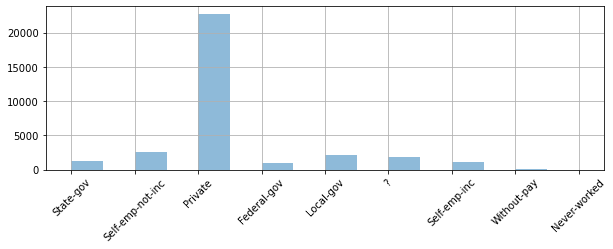

In [127]:
cat = list(categories_dict.keys())[0]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

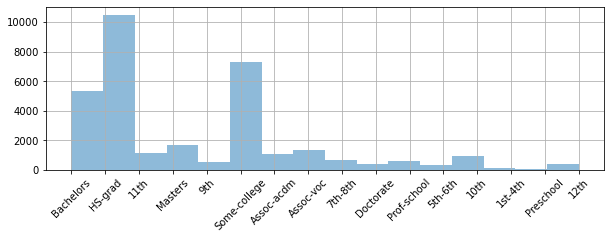

In [128]:
cat = list(categories_dict.keys())[1]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

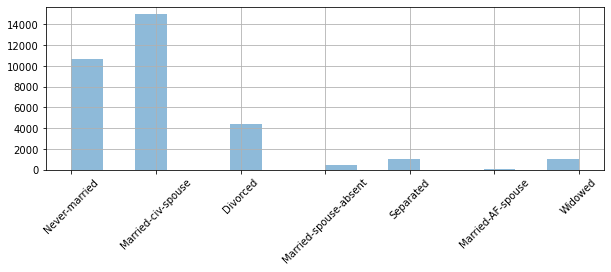

In [129]:
cat = list(categories_dict.keys())[2]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

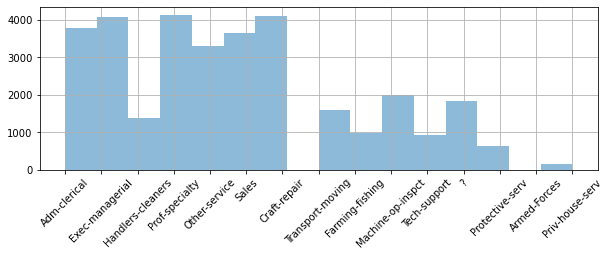

In [130]:
cat = list(categories_dict.keys())[3]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

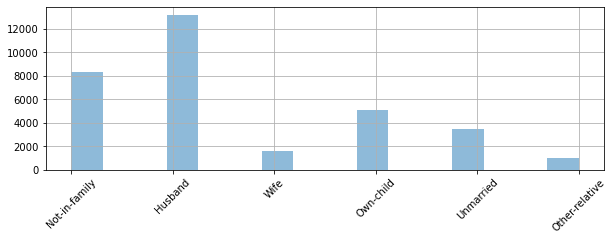

In [131]:
cat = list(categories_dict.keys())[4]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

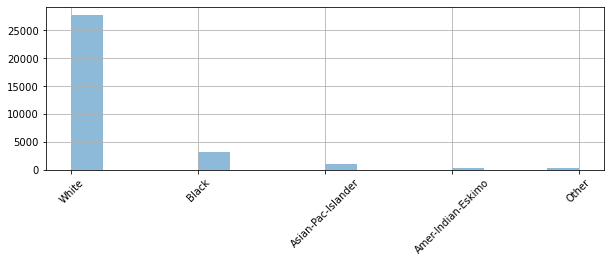

In [132]:
cat = list(categories_dict.keys())[5]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

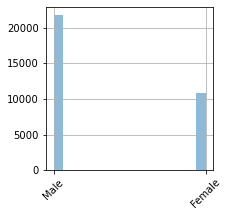

In [133]:
cat = list(categories_dict.keys())[6]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(3,3));

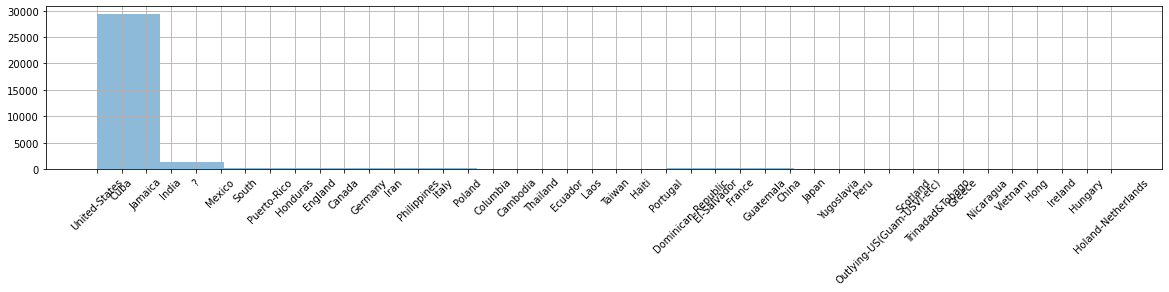

In [134]:
cat = list(categories_dict.keys())[7]
plt.xticks(rotation=45)
data[cat].hist(bins=16, alpha = .5, figsize=(20,3));

# replace '?' for NaN

In [135]:
data = data.replace(['?'],np.nan)
data_test = data_test.replace(['?'],np.nan)

# report data types

#### continuous

In [136]:
numerical_cols = get_numerical_mask(data)
numerical_cols.remove('y')
print(numerical_cols)

num_df = pd.DataFrame(numerical_cols)

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


#### non continuous

In [137]:
non_numerical_cols = set(data.columns) - set(numerical_cols)
non_numerical_cols.remove('y')
other_df = pd.DataFrame(non_numerical_cols)

#### concatenate

In [138]:
report_df = pd.concat([num_df,other_df], ignore_index=True, axis=1)
report_df.columns = ['numerical_cols', 'non_numerical_cols']

# Checking  for possible anomalies in the database
Here we check for some possible anomalies. If there was one, we should look for solutions such as: contact the team responsible for data engineering or anyone who has a good understanding of the provided data, search for flaws in the data pipeline, or at least document for those anomalies.

Check if there is any oddity in data.

In [139]:
len(numerical_cols)

5

In [140]:
data.loc[:, numerical_cols].describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


# boxplots
This is useful to check for outliers, which will be handled later. Also, some values might be misleading, requiring a preimputation step. For instance: hours per week shouldn't surpass 140. Age shouldn't go well beyond 90.

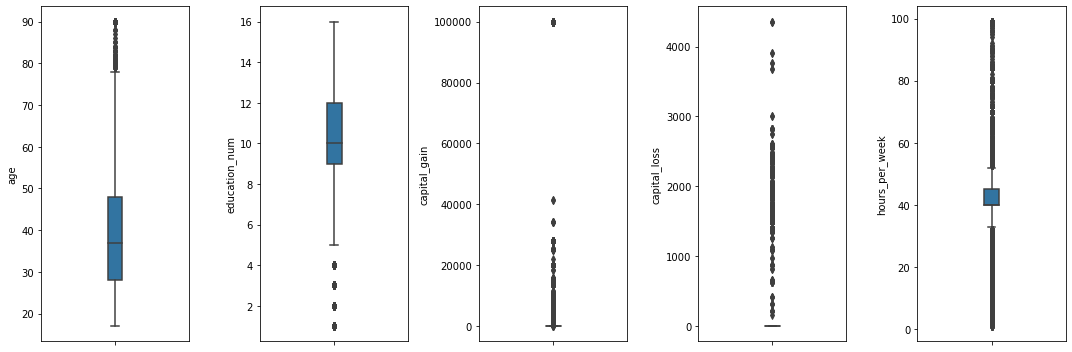

In [141]:
build_boxplots(data[numerical_cols])

# Description (2nd round)

In [142]:
data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week,y
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


# save data

In [143]:
data.to_csv(os.path.join(outputs, 'data.csv'))
data_test.to_csv(os.path.join(outputs, 'data_test.csv'))

# save report over data types

In [144]:
report_df.to_csv(os.path.join(reports, 'data_types.csv'), index=False)